In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from pathlib import Path
import preproc as pp

import numpy as np
import tensorflow as tf

version = "v2"
augp = Path("../scratch").joinpath("train_augmented_" + version)
modelp = Path("../scratch").joinpath("models")

train_ir, test_ir = pp.load_data(val_size=0)
train_aug, test_aug = pp.load_aug_data(augp, train_ir.element_spec, test_ind=[5])

In [2]:
a = tf.keras.applications.vgg16.VGG16()
a.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 3.0 VGG Base

In [3]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggbase = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
vggbase.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [4]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 22s 24ms/step - loss: 0.5830 - accuracy: 0.8104 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 2/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.0316 - val_accuracy: 0.9912
Epoch 3/100
844/844 [==============================] - 21s 23ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0313 - val_accuracy: 0.9920
Epoch 4/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0373 - val_accuracy: 0.9919
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0335 - val_accuracy: 0.9924
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 0.0456 - val_accuracy: 0.9919


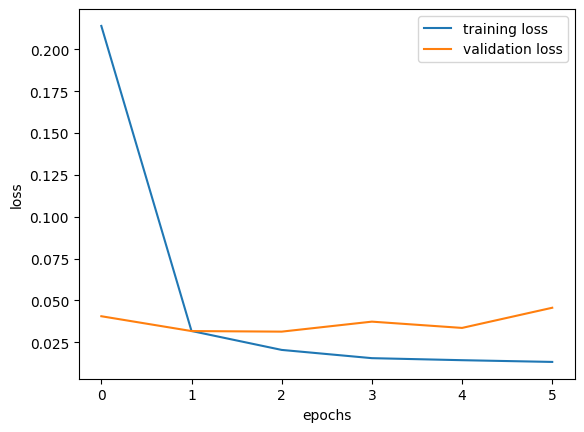

In [6]:
import datetime

vggbase.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = vggbase.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [10]:
_ = vggbase.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0198 - accuracy: 0.9956


In [11]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

vggbase.evaluate(x_train, y_train), vggbase.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0429 - accuracy: 0.9902


([0.030315332114696503, 0.9943666458129883],
 [0.042939815670251846, 0.9901999831199646])

In [12]:
pp.plot_confusion_matrix(x_test, y_test, vggbase)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 976,    0,    0,    0,    0,    0,    2,    1,    1,    0],
       [   0, 1131,    0,    1,    0,    0,    0,    2,    0,    1],
       [   0,    1, 1025,    0,    0,    0,    0,    6,    0,    0],
       [   0,    1,    0, 1008,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,  974,    0,    0,    0,    0,    8],
       [   0,    1,    1,   21,    0,  864,    1,    1,    3,    0],
       [   1,    5,    0,    0,    2,    0,  947,    0,    3,    0],
       [   0,    3,    0,    2,    0,    0,    0, 1018,    1,    4],
       [   0,    0,    2,    5,    0,    1,    0,    0,  966,    0],
       [   0,    0,    0,    7,    9,    0,    0,    0,    0,  993]],
      dtype=int32)>

In [13]:
vggbase.evaluate(train_ds), vggbase.evaluate(val_ds), vggbase.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 12ms/step - loss: 0.3835 - accuracy: 0.9579


([0.37606409192085266, 0.961597204208374],
 [0.3832643926143646, 0.959324061870575],
 [0.3834851384162903, 0.9579333066940308])

In [14]:
vggbase.save(modelp.joinpath("vggbase." + version + ".h5").resolve().as_posix(), save_format="h5")

# 3.1 VGG Dropout

In [15]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggreg = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggreg
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [16]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 21s 22ms/step - loss: 0.5732 - accuracy: 0.8097 - val_loss: 0.0482 - val_accuracy: 0.9859
Epoch 2/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0470 - accuracy: 0.9863 - val_loss: 0.0352 - val_accuracy: 0.9893
Epoch 3/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0333 - accuracy: 0.9902 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 4/100
844/844 [==============================] - 21s 22ms/step - loss: 0.0285 - accuracy: 0.9918 - val_loss: 0.0274 - val_accuracy: 0.9925
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.0224 - val_accuracy: 0.9933
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0266 - accuracy: 0.9928 - val_loss: 0.0245 - val_accuracy: 0.9926
Epoch 7/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0253 - accuracy: 0.9930 - val_loss: 0.0264 - val_ac

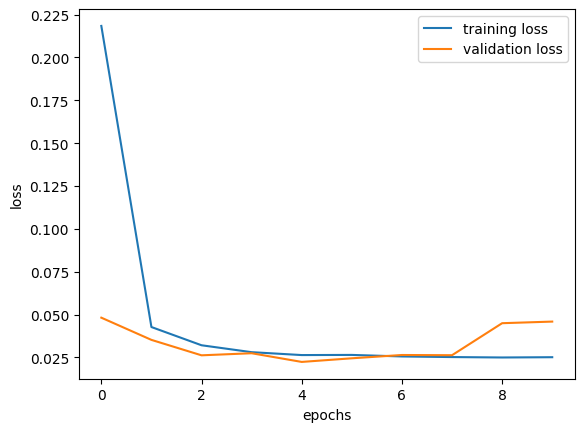

In [17]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=5)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [21]:
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0280 - accuracy: 0.9936


In [22]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9902


([0.03156949207186699, 0.994350016117096],
 [0.06912887841463089, 0.9901999831199646])

In [23]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 979,    0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0, 1131,    2,    1,    0,    0,    1,    0,    0,    0],
       [   1,    0, 1028,    3,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1010,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,  975,    0,    1,    1,    0,    4],
       [   0,    0,    0,   13,    0,  876,    2,    1,    0,    0],
       [   6,    2,    0,    0,    1,    0,  949,    0,    0,    0],
       [   0,    4,   22,    8,    0,    0,    0,  990,    0,    4],
       [   0,    0,    1,    7,    1,    1,    0,    0,  964,    0],
       [   0,    0,    0,    2,    7,    0,    0,    0,    0, 1000]],
      dtype=int32)>

In [24]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 12ms/step - loss: 0.0773 - accuracy: 0.9831


([0.06191731244325638, 0.9849722385406494],
 [0.07827036082744598, 0.9830740690231323],
 [0.07733505964279175, 0.9831166863441467])

In [25]:
net.save(modelp.joinpath("vgg_3.1."+version+".h5").resolve().as_posix(), save_format="h5")

# 3.2 VGG 3.1 Mod1

In [26]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggbase = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(64, 3)
    + conv_block(128, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            1024
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.5)
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggbase
net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [27]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/100
844/844 [==============================] - 21s 22ms/step - loss: 0.5632 - accuracy: 0.8134 - val_loss: 0.0582 - val_accuracy: 0.9825
Epoch 2/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0507 - accuracy: 0.9851 - val_loss: 0.0358 - val_accuracy: 0.9898
Epoch 3/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0366 - accuracy: 0.9898 - val_loss: 0.0338 - val_accuracy: 0.9906
Epoch 4/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0328 - accuracy: 0.9910 - val_loss: 0.0393 - val_accuracy: 0.9895
Epoch 5/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0326 - accuracy: 0.9912 - val_loss: 0.0302 - val_accuracy: 0.9924
Epoch 6/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0324 - accuracy: 0.9915 - val_loss: 0.0482 - val_accuracy: 0.9909
Epoch 7/100
844/844 [==============================] - 20s 22ms/step - loss: 0.0327 - accuracy: 0.9917 - val_loss: 0.0334 - val_ac

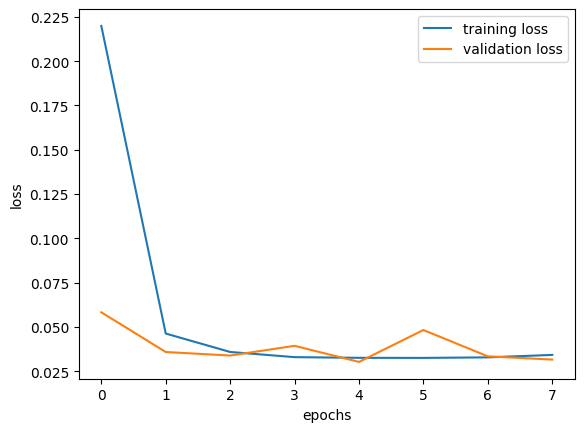

In [28]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer="rmsprop"
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=100
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=3)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [32]:
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 11ms/step - loss: 0.0351 - accuracy: 0.9919


In [33]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0266 - accuracy: 0.9934


([0.01415741816163063, 0.9958166480064392],
 [0.02656857669353485, 0.993399977684021])

In [34]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 979,    0,    0,    0,    0,    0,    1,    0,    0,    0],
       [   4, 1120,    0,    1,    1,    0,    7,    0,    2,    0],
       [   0,    0, 1031,    0,    0,    0,    0,    1,    0,    0],
       [   0,    0,    3, 1004,    0,    2,    0,    0,    1,    0],
       [   0,    0,    0,    0,  976,    0,    0,    0,    2,    4],
       [   0,    0,    0,    1,    0,  888,    2,    1,    0,    0],
       [   3,    0,    0,    0,    1,    1,  952,    0,    1,    0],
       [   0,    2,    8,    0,    0,    0,    0, 1017,    0,    1],
       [   1,    0,    3,    0,    0,    1,    0,    0,  969,    0],
       [   0,    0,    0,    1,    4,    1,    0,    1,    4,  998]],
      dtype=int32)>

In [35]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 2s 13ms/step - loss: 0.0752 - accuracy: 0.9793


([0.06492283195257187, 0.9818541407585144],
 [0.07586977630853653, 0.9792037010192871],
 [0.07519837468862534, 0.9793499708175659])

In [77]:
net.save(modelp.joinpath("vgg_3.1mod1."+version+".h5").resolve().as_posix(), save_format="h5")

# 3.3 VGG 3.1 Mod2

In [45]:
def conv_block(filters, kernel_size):
    return [
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.Conv2D(
            filters=filters
            , kernel_size=kernel_size
            , strides=1
            , padding="same"
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(
            pool_size=2,
            strides=2,
            padding="valid"
        )
    ]

vggreg = tf.keras.Sequential([tf.keras.Input(shape=(28, 28, 1))]
    + conv_block(32, 3)
    + conv_block(64, 3)
    + [
        tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dropout(0.3)
        , tf.keras.layers.Dense(
            512
            , activation="relu"
            , use_bias=True
            , kernel_initializer="glorot_uniform"
            , bias_initializer="zeros"
        )
        , tf.keras.layers.Dense(
            10
            , activation="softmax"
        )
    ]
)
net = vggreg
net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

In [27]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/300
844/844 [==============================] - 20s 20ms/step - loss: 0.3595 - accuracy: 0.8872 - val_loss: 0.0680 - val_accuracy: 0.9786
Epoch 2/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0571 - accuracy: 0.9824 - val_loss: 0.0412 - val_accuracy: 0.9869
Epoch 3/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0400 - accuracy: 0.9874 - val_loss: 0.0545 - val_accuracy: 0.9827
Epoch 4/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.0423 - val_accuracy: 0.9869
Epoch 5/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0495 - val_accuracy: 0.9849
Epoch 6/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0210 - accuracy: 0.9932 - val_loss: 0.0249 - val_accuracy: 0.9923
Epoch 7/300
844/844 [==============================] - 17s 18ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0247 - val_ac

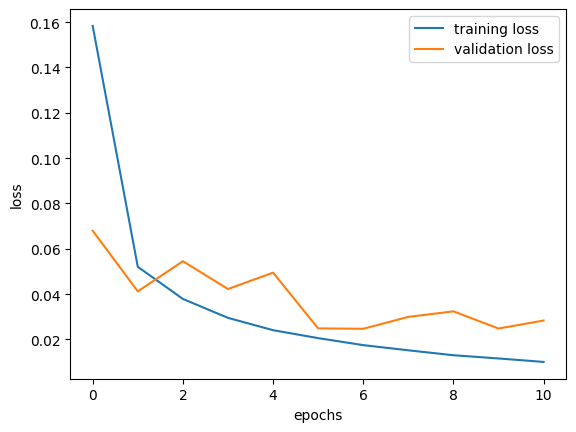

In [47]:
import datetime

net.compile(
    loss='categorical_crossentropy'
    , optimizer=tf.keras.optimizers.SGD(nesterov=True, momentum=0.9)
    , metrics=["accuracy"]
)

history = net.fit(
    train_ds
    , validation_data=val_ds
    , epochs=300
    , callbacks=[
        tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
        , tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-5)
    ]
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [38]:
# epochs=1
_ = net.fit(x_train, y_train, epochs=1, batch_size=512)

118/118 [==============================] - 1s 7ms/step - loss: 0.0132 - accuracy: 0.9958


In [39]:
augp = Path("../scratch").joinpath("train_augmented_v1")
# epochs=1
train_aug, _ = pp.load_aug_data(augp.resolve(), train_ir.element_spec, test_ind=[])
_ = net.fit(train_aug.batch(512), epochs=1)

1172/1172 [==============================] - 18s 15ms/step - loss: 0.0049 - accuracy: 0.9985


In [16]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0315 - accuracy: 0.9921


([0.01553743053227663, 0.9956833124160767],
 [0.03149672970175743, 0.9921000003814697])

In [17]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 978,    0,    0,    0,    0,    1,    0,    1,    0,    0],
       [   0, 1131,    1,    1,    0,    0,    0,    2,    0,    0],
       [   2,    0, 1021,    3,    0,    0,    0,    5,    1,    0],
       [   0,    0,    0, 1008,    0,    1,    0,    1,    0,    0],
       [   0,    0,    0,    0,  970,    0,    0,    2,    2,    8],
       [   0,    0,    0,    3,    0,  885,    3,    1,    0,    0],
       [   6,    2,    0,    1,    1,    1,  946,    0,    1,    0],
       [   0,    1,    6,    1,    0,    0,    0, 1019,    0,    1],
       [   0,    0,    1,    1,    1,    2,    0,    1,  967,    1],
       [   0,    0,    0,    0,    7,    2,    0,    3,    1,  996]],
      dtype=int32)>

In [28]:
test_aug_lab = np.array(list(test_aug.map(lambda _, y: y).as_numpy_iterator()))
test_aug_preds = np.array(list(net.predict(test_aug.batch(512))))
tf.math.confusion_matrix(np.argmax(test_aug_lab, axis=1), np.argmax(test_aug_preds, axis=1))

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5443,   15,   73,   30,   18,   45,   93,   60,   30,  116],
       [   6, 6037,  231,    5,   17,   93,   26,  319,    3,    5],
       [  75,   32, 4809,   88,  161,   38,   50,  383,  236,   86],
       [  77,   10,  140, 5169,  159,  131,   74,  275,   49,   47],
       [  14,  106,  157,   62, 4687,  238,   34,  211,  233,  100],
       [  81,   24,   31,   55,  136, 4544,  213,  106,   40,  191],
       [ 104,   54,   94,   42,   74,  379, 4912,    4,  106,  149],
       [  38,  204,  471,  116,   94,   95,    3, 5175,   15,   54],
       [ 108,   21,  242,   38,  142,   87,  173,   30, 4748,  262],
       [ 110,   27,  147,   53,  126,  277,   53,  104,  180, 4872]],
      dtype=int32)>

In [ ]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

 16/118 [===>..........................] - ETA: 1s - loss: 1.1526 - accuracy: 0.8469

In [49]:
net.save(modelp.joinpath("vgg_3.1mod2."+version+".h5").resolve().as_posix(), save_format="h5")